In [55]:
# !pip install datasets

In [56]:
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="./tom_and_jerry")
print(dataset)
dataset = dataset["train"]

dataset = dataset.shuffle(seed=1234).select(range(2000)) # 🤔
dataset = dataset.train_test_split(test_size=0.3, seed=1234) # 🤔
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 2470
    })
})


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1400
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 600
    })
})

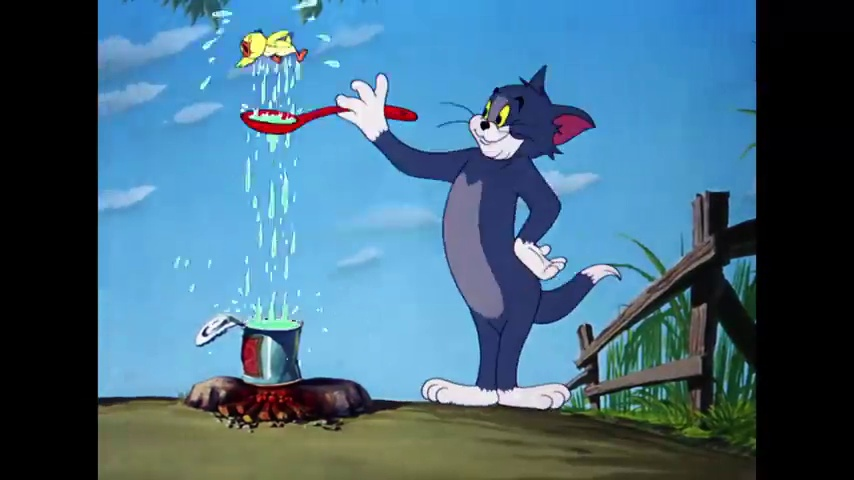

In [57]:
dataset["train"][0]["image"]

In [58]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

id2label

{'0': 'jerry', '1': 'tom'}

In [59]:
# !pip install torch torchvision torchaudio
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

# !pip install transformers

In [60]:
import torch

print(torch.cuda.is_available())

def set_device():
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    return torch.device(dev)

True


In [61]:
from transformers import AutoImageProcessor

checkpoint = "microsoft/resnet-50" # 🤔
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [62]:
from torchvision.transforms import Resize, RandomResizedCrop, RandomHorizontalFlip, RandomRotation, ColorJitter, Compose, Normalize, ToTensor # 🤔

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = image_processor.size["shortest_edge"] if "shortest_edge" in image_processor.size else (image_processor.size["height"], image_processor.size["width"])
_transforms = Compose([Resize(256), Resize(224), ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), ToTensor(), normalize]) # 🤔

def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

dataset = dataset.with_transform(transforms)
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1400
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 600
    })
})

In [63]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()
data_collator

DefaultDataCollator(return_tensors='pt')

In [64]:
# !pip install evaluate
# !pip install scikit-learn

In [65]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [66]:
# !pip install accelerate
# !pip install optuna

In [67]:
# import optuna
# from transformers import Trainer, TrainingArguments, AutoModelForImageClassification
# from torch.optim import AdamW
# from torch.optim.lr_scheduler import CosineAnnealingLR

# def objective(trial):
#     # Define hyperparameters to tune
#     learning_rate = trial.suggest_loguniform('learning_rate', 1e-6, 1e-4)
#     T_max = trial.suggest_int('T_max', 10, 50)
#     per_device_train_batch_size = trial.suggest_categorical('per_device_train_batch_size', [8, 16, 32])
    
#     # Initialize model (use your pre-trained model here)
#     model = AutoModelForImageClassification.from_pretrained(
#         checkpoint,
#         num_labels=len(labels),
#         id2label=id2label,
#         label2id=label2id,
#         ignore_mismatched_sizes=True,
#     )
    
#     # Define the optimizer
#     optimizer = AdamW(model.parameters(), lr=learning_rate)
    
#     # Define the learning rate scheduler
#     scheduler = CosineAnnealingLR(optimizer, T_max=T_max)
    
#     # Training arguments
#     training_args = TrainingArguments(
#         output_dir="test_my_image_model", 
#         remove_unused_columns=False,
#         evaluation_strategy="epoch", 
#         save_strategy="epoch",
#         learning_rate=learning_rate,
#         per_device_train_batch_size=per_device_train_batch_size,
#         gradient_accumulation_steps=1,
#         per_device_eval_batch_size=8,
#         num_train_epochs=3.0,
#         warmup_ratio=0.0,
#         logging_steps=500,
#         load_best_model_at_end=True,
#         metric_for_best_model="accuracy",
#     )

#     # Trainer
#     trainer = Trainer(
#         model=model,
#         args=training_args,
#         data_collator=data_collator,
#         train_dataset=dataset["train"],
#         eval_dataset=dataset["test"],
#         tokenizer=image_processor,
#         compute_metrics=compute_metrics,
#         optimizers=(optimizer, scheduler)  # Pass optimizer and scheduler here
#     )

#     # Train the model
#     trainer.train()

#     # Evaluate and return the evaluation metric you want to optimize
#     eval_result = trainer.evaluate()
#     return eval_result['eval_accuracy']


In [68]:
# # Create a study to maximize accuracy
# study = optuna.create_study(direction="maximize")

# # Run the optimization over 20 trials (you can increase this number)
# study.optimize(objective, n_trials=20)

# # Print the best trial
# print(f"Best trial: {study.best_trial.params}")

In [69]:
# best_trial = study.best_trial

# # Use the best hyperparameters
# best_learning_rate = best_trial.params['learning_rate']
# best_T_max = best_trial.params['T_max']
# best_batch_size = best_trial.params['per_device_train_batch_size']

# Re-train or fine-tune the model with the best hyperparameters
# optimizer = AdamW(model.parameters(), lr=best_learning_rate)
# scheduler = CosineAnnealingLR(optimizer, T_max=best_T_max)

In [70]:
import os
import shutil
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

def clear_output_dir(output_dir):
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
        print(f"Cleared the directory: {output_dir}")

clear_output_dir("my_image_model")
clear_output_dir("my_final_image_model")

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)
    
training_args = TrainingArguments(
    output_dir="my_image_model", # 🤔
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch", # 🤔
    learning_rate=1e-3, # 🤔
    per_device_train_batch_size=16, # 🤔
    gradient_accumulation_steps=4, # 🤔
    per_device_eval_batch_size=16, # 🤔
    num_train_epochs=10.0, # 🤔
    warmup_ratio=0.1, # 🤔
    logging_steps=500, # 🤔
    load_best_model_at_end=True, # 🤔
    metric_for_best_model="accuracy",
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model("my_final_image_model") # 🤔

Cleared the directory: my_image_model
Cleared the directory: my_final_image_model


Some weights of ResNetForImageClassification were not initialized from the model checkpoint at microsoft/resnet-50 and are newly initialized because the shapes did not match:
- classifier.1.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.1.weight: found shape torch.Size([1000, 2048]) in the checkpoint and torch.Size([2, 2048]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 10%|█         | 22/220 [00:59<06:28,  1.96s/it]

{'eval_loss': 0.31670644879341125, 'eval_accuracy': 0.9166666666666666, 'eval_runtime': 12.6479, 'eval_samples_per_second': 47.439, 'eval_steps_per_second': 3.004, 'epoch': 1.0}


 20%|██        | 44/220 [01:59<05:54,  2.01s/it]

{'eval_loss': 0.06840891391038895, 'eval_accuracy': 0.9716666666666667, 'eval_runtime': 12.767, 'eval_samples_per_second': 46.996, 'eval_steps_per_second': 2.976, 'epoch': 2.0}


 30%|███       | 66/220 [03:01<05:16,  2.06s/it]

{'eval_loss': 0.037143681198358536, 'eval_accuracy': 0.9866666666666667, 'eval_runtime': 13.5726, 'eval_samples_per_second': 44.207, 'eval_steps_per_second': 2.8, 'epoch': 3.0}


 40%|████      | 88/220 [04:06<04:39,  2.12s/it]

{'eval_loss': 0.0427396185696125, 'eval_accuracy': 0.9883333333333333, 'eval_runtime': 13.7353, 'eval_samples_per_second': 43.683, 'eval_steps_per_second': 2.767, 'epoch': 4.0}


 50%|█████     | 110/220 [05:16<04:18,  2.35s/it]

{'eval_loss': 0.04768580570816994, 'eval_accuracy': 0.98, 'eval_runtime': 15.7307, 'eval_samples_per_second': 38.142, 'eval_steps_per_second': 2.416, 'epoch': 5.0}


 60%|██████    | 132/220 [06:20<03:07,  2.13s/it]

{'eval_loss': 0.03623759374022484, 'eval_accuracy': 0.9883333333333333, 'eval_runtime': 13.4844, 'eval_samples_per_second': 44.496, 'eval_steps_per_second': 2.818, 'epoch': 6.0}


 70%|███████   | 154/220 [07:24<02:18,  2.11s/it]

{'eval_loss': 0.0381813570857048, 'eval_accuracy': 0.99, 'eval_runtime': 13.8922, 'eval_samples_per_second': 43.19, 'eval_steps_per_second': 2.735, 'epoch': 7.0}


 80%|████████  | 176/220 [08:28<01:33,  2.12s/it]

{'eval_loss': 0.02954399771988392, 'eval_accuracy': 0.99, 'eval_runtime': 13.6917, 'eval_samples_per_second': 43.822, 'eval_steps_per_second': 2.775, 'epoch': 8.0}


 90%|█████████ | 198/220 [09:33<00:46,  2.09s/it]

{'eval_loss': 0.03895924240350723, 'eval_accuracy': 0.99, 'eval_runtime': 13.645, 'eval_samples_per_second': 43.972, 'eval_steps_per_second': 2.785, 'epoch': 9.0}


100%|██████████| 220/220 [10:37<00:00,  2.15s/it]

{'eval_loss': 0.03423492610454559, 'eval_accuracy': 0.99, 'eval_runtime': 13.5435, 'eval_samples_per_second': 44.302, 'eval_steps_per_second': 2.806, 'epoch': 10.0}


100%|██████████| 220/220 [10:38<00:00,  2.90s/it]

{'train_runtime': 638.1408, 'train_samples_per_second': 21.939, 'train_steps_per_second': 0.345, 'train_loss': 0.08694658279418946, 'epoch': 10.0}


In [71]:
results = trainer.evaluate()
print(results)

100%|██████████| 38/38 [00:13<00:00,  2.87it/s]

{'eval_loss': 0.04123251140117645, 'eval_accuracy': 0.9883333333333333, 'eval_runtime': 13.9471, 'eval_samples_per_second': 43.02, 'eval_steps_per_second': 2.725, 'epoch': 10.0}


In [72]:
dataset = load_dataset("imagefolder", data_dir="./tom_and_jerry")
dataset = dataset["train"]

dataset = dataset.shuffle(seed=1234).select(range(2000)) # 🤔
dataset = dataset.train_test_split(test_size=0.3, seed=1234) # 🤔
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1400
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 600
    })
})

tom


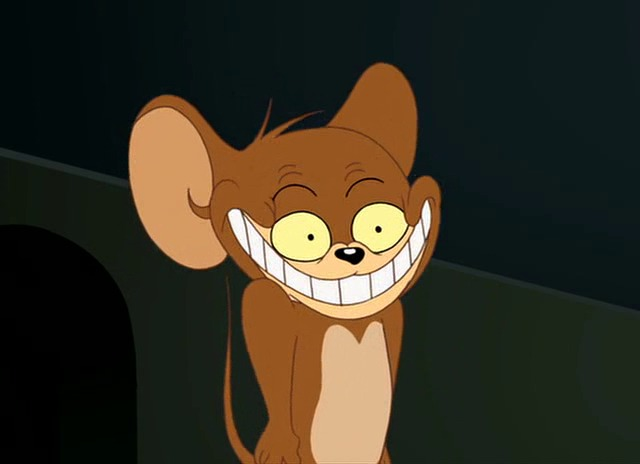

In [96]:
image = dataset["test"][11] # 🤔
print(id2label[str(image['label'])])
image = image['image']
image

In [97]:
from transformers import pipeline

classifier = pipeline("image-classification", model="./my_final_image_model")
print(classifier(image)[0]["label"])
classifier(image)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


jerry


[{'label': 'jerry', 'score': 0.9559388160705566},
 {'label': 'tom', 'score': 0.05546926334500313}]